# Time Series Project

In this project we are using Sweet Lift Taxi historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. We will build a model for such a prediction using time series data. The RMSE metric on the test set should not be more than 48.

In [1]:
# #conda install -c conda-forge lightgbm
# !pip install lightgbm
# !pip install xgboost
#!pip install scikit-learn --upgrade
#!pip install scikit-learn
#! pip install -qU seaborn
#! pip install seaborn

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
data = pd.read_csv('C:/Users/vital/Downloads/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Data is in 10 minutes friquency

In [5]:
#Make sure the data is ordered
data.sort_index(inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Time range is from March 1, 2018 - Aug 31, 2018

**Resample the data by hour**

In [7]:
data_hour = data.resample('1H').sum()

In [8]:
data_hour.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Analyzing the data

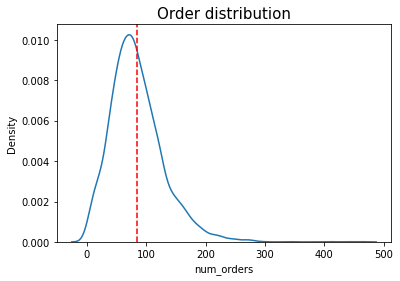

In [9]:
sns.kdeplot(data_hour['num_orders'])
plt.axvline(x=data_hour['num_orders'].mean(), color='r', linestyle='--')
plt.title('Order distribution', size=15)
plt.show()

In [10]:
print('Average daily oreders:',data_hour['num_orders'].mean())

Average daily oreders: 84.42278079710145


Average number of daily orders is 84. The orders are normally distributed with small number of outliers.

In [11]:
#Look ar mean per month
data_hour.groupby(data_hour.index.month)['num_orders'].mean()

datetime
3     57.483871
4     63.804167
5     73.682796
6     83.202778
7    100.006720
8    127.651882
Name: num_orders, dtype: float64

We see that the average increases per month - non statitionary data

In [12]:
#Create daily average
data_hour['rolling_mean'] = data_hour['num_orders'].rolling(24).mean()

In [13]:
#Create daily sd
data_hour['rolling_sd'] = data_hour['num_orders'].rolling(24).std()

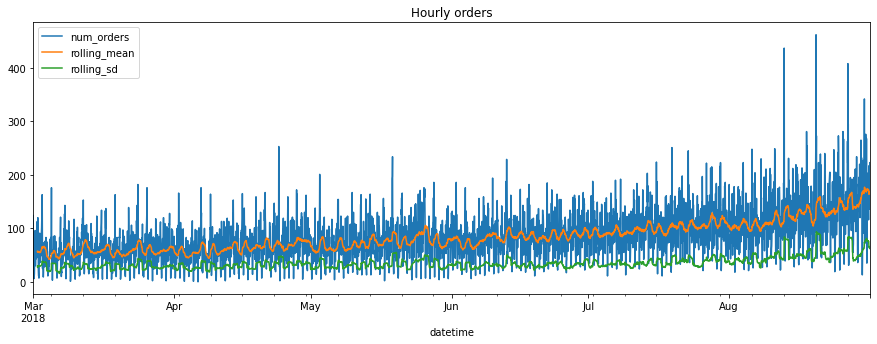

In [14]:
#See data behavior
plt.figure(figsize=(15,5))
data_hour.plot(ax=plt.gca())
plt.title('Hourly orders')
plt.show()

Hourly data is very fluctuated, between 0 to 200 orders per hour and increasing in the summer with up to around 400 orders. Looking at the mean we see an increasing trend and also the SD is  increasing - meaning not statitionary.

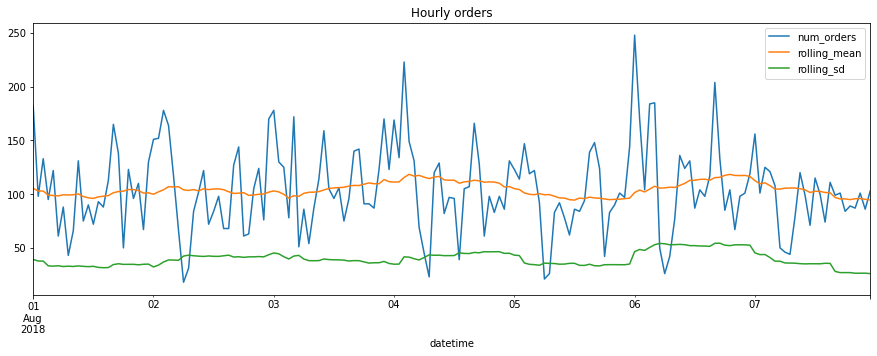

In [15]:
#See one week data behavior
plt.figure(figsize=(15,5))
data_hour['2018-08-01':'2018-08-07'].plot(ax=plt.gca())
plt.title('Hourly orders')
plt.show()

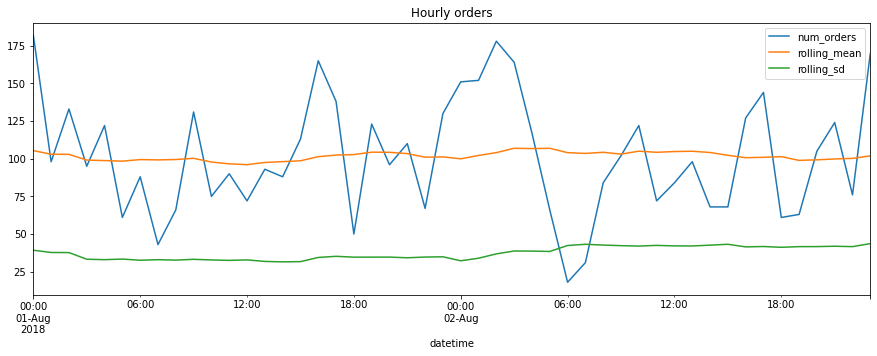

In [16]:
#See two days data behavior
plt.figure(figsize=(15,5))
data_hour['2018-08-01':'2018-08-02'].plot(ax=plt.gca())
plt.title('Hourly orders')
plt.show()

We see that hours are very importnat for preidiction and effecting seasonality.

In [17]:
#Check for statitionaty data
#Null hypothesis: the data is stationary

from statsmodels.tsa.stattools import adfuller

print('Dickey-Fuller test:')
dftest = adfuller(data_hour['num_orders'], autolag='AIC')

dfoutput = pd.Series(dftest[0:2], index=['Test statistic','p-value'])
print(dfoutput)

Dickey-Fuller test:
Test statistic   -3.068924
p-value           0.028940
dtype: float64


P-value is less tham 5%, we can reject null hypothesis, meaning the data is non stationary when looking at daily at all preiod on a hourly basis

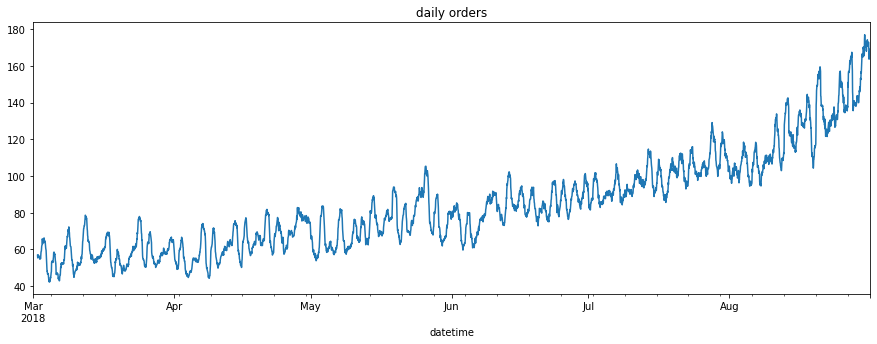

In [18]:
#See smoothed data behavior - 24 hours average

plt.figure(figsize=(15,5))
data_hour['num_orders'].rolling(24).mean().plot(ax=plt.gca())
plt.title('daily orders')
plt.show()

Smoothing the data into 24 hours average we see increasing trend.

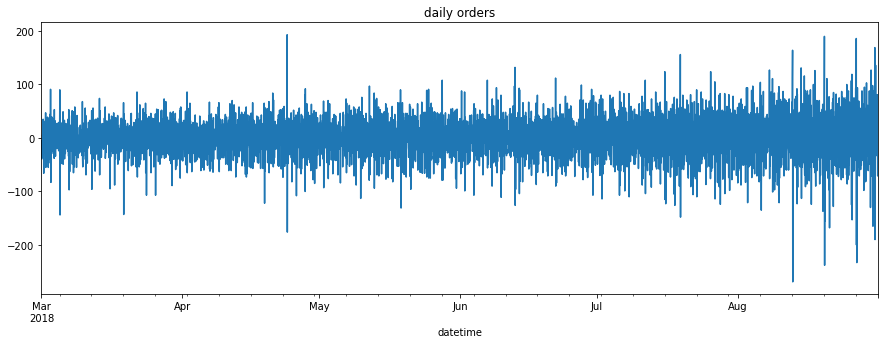

In [19]:
#See differences in  data behavior

plt.figure(figsize=(15,5))
(data_hour['num_orders']-data_hour['num_orders'].shift()).plot(ax=plt.gca())
plt.title('daily orders')
plt.show()

Looking at differences between days, we see increase in hourly differences at the end of the period.

**Trend, seasonality and residuals**

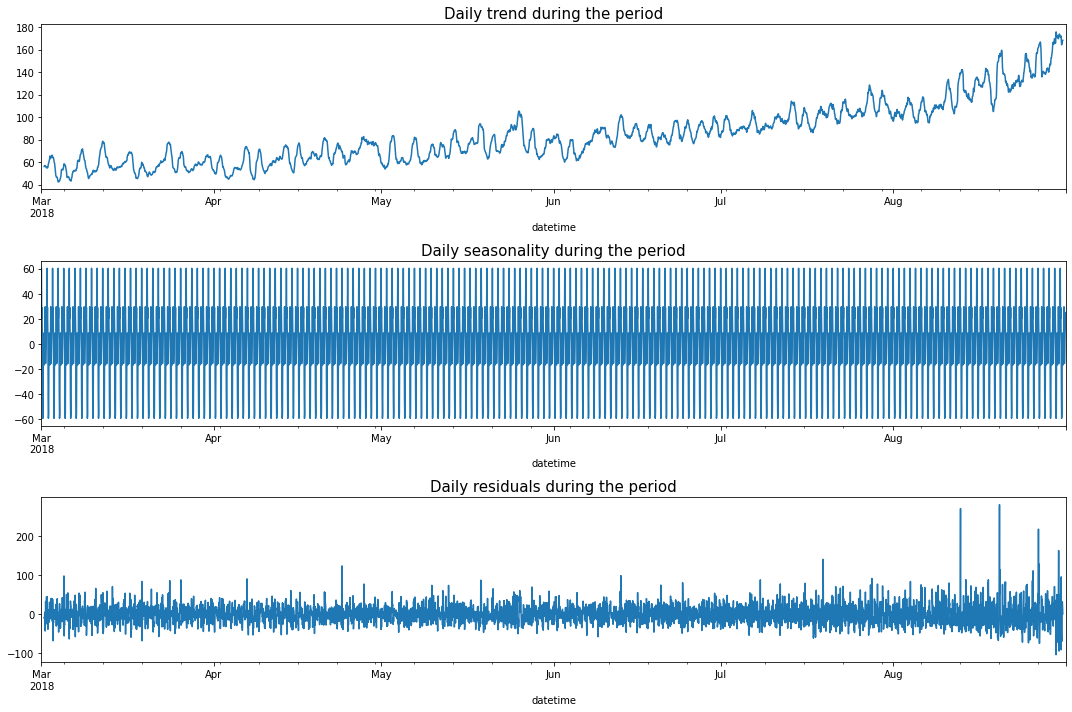

In [20]:
decomposition = seasonal_decompose(data_hour['num_orders'])

#Visualize trend, seasonality and residuals
plt.figure(figsize=(15,10))

plt.subplot(311)
decomposition.trend.plot(ax=plt.gca())
plt.title('Daily trend during the period', size=15)

plt.subplot(312)
decomposition.seasonal.plot(ax=plt.gca())
plt.title('Daily seasonality during the period', size=15)

plt.subplot(313)
decomposition.resid.plot(ax=plt.gca())
plt.title('Daily residuals during the period', size=15)

plt.tight_layout()

We see that there is an increasing trend during the whole period from 50 hourly order to 175 hourly orders, we see daily **seasonality** of +/- 60 orders per hour which is **stationary stochastic process** as the values does not change over time, and also daily residuals which are around +/- 40 at the begining of the period and some outliers of around 300 order at the end of the period. 

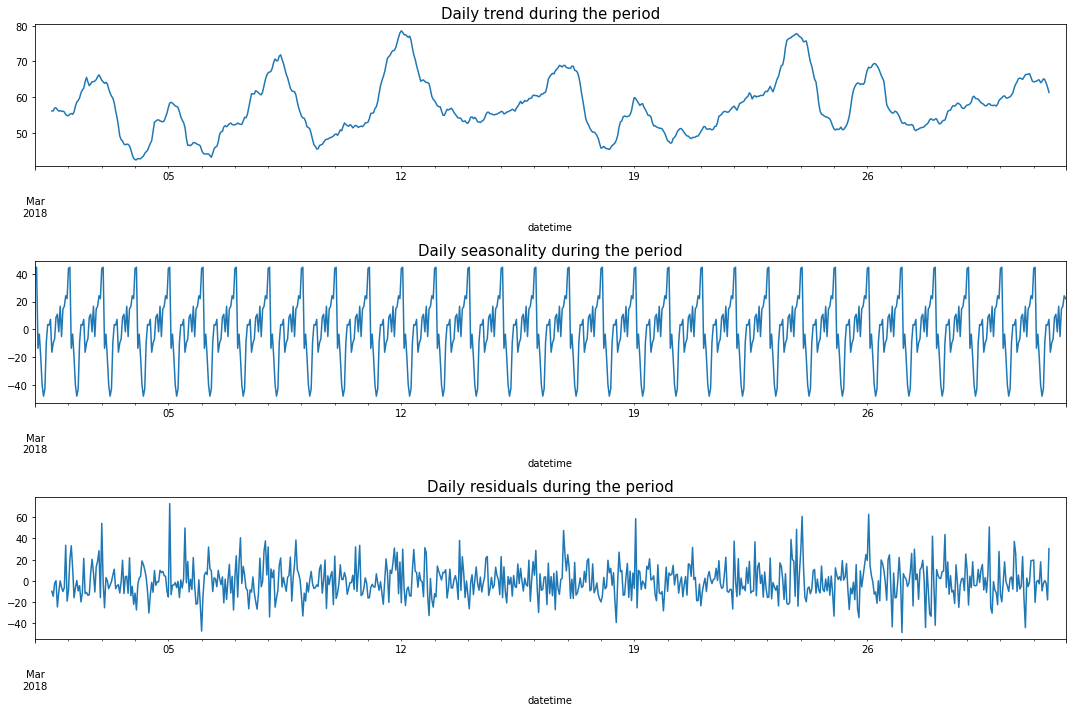

In [21]:
#Look at smaller preiod - March 2018

decomposition_month = seasonal_decompose(data_hour['num_orders']['2018-03':'2018-03'])
#Visualize trend, seasonality and residuals
plt.figure(figsize=(15,10))

plt.subplot(311)
decomposition_month.trend.plot(ax=plt.gca())
plt.title('Daily trend during the period', size=15)

plt.subplot(312)
decomposition_month.seasonal.plot(ax=plt.gca())
plt.title('Daily seasonality during the period', size=15)

plt.subplot(313)
decomposition_month.resid.plot(ax=plt.gca())
plt.title('Daily residuals during the period', size=15)

plt.tight_layout()

During March, the trend is not stable, the seasonality is stationary stochastic

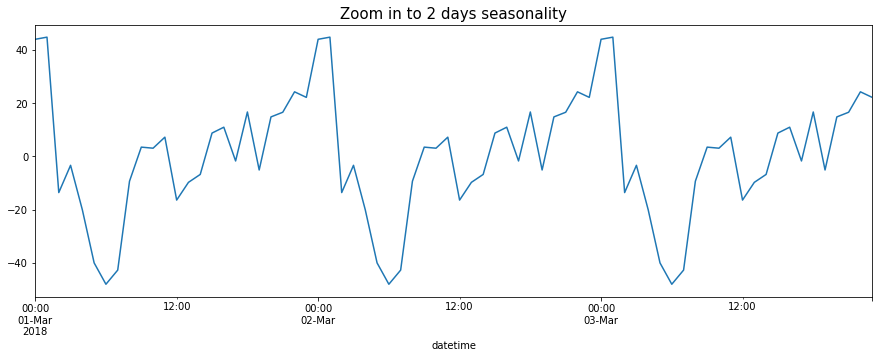

In [22]:
plt.figure(figsize=(15,5))
plt.title('Zoom in to 2 days seasonality', size=15)
decomposition_month.seasonal['2018-03-01':'2018-03-03'].plot()
plt.show()

We Can see that seasonality is depended on hours, high demand during night and low demand at early morning hours.

### Feature engineering

In [23]:
#Function that gets the data, days to lag, rolling size for mean and sum, and
#two sided for seasonal_decompose in order to calculate forword rolling average or not.

def feat_engineer(data, lag, rolling_size):
    data['dayofweek'] = data.index.dayofweek
    data['day'] = data.index.day
    data['month'] = data.index.month
    data['week'] = data.index.week
    data['hour'] = data.index.hour
    
    for lag in range(1,lag+1,1):
        data['lag_'+str(lag)] = data.iloc[:,0].shift(lag)  
        
    #Rolling mean for previos days, to not get overfitted and avoid calculating the target as part of the mean
    data['rolling_mean'] = data.iloc[:,0].shift().rolling(rolling_size).mean()

In [24]:
feat_engineer(data_hour, 5,5)

<ipython-input-23-e51ac753abe0>:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data['week'] = data.index.week


In [25]:
data_hour.head(10)

,num_orders,rolling_mean,rolling_sd,dayofweek,day,month,week,hour,lag_1,lag_2,lag_3,lag_4,lag_5
datetime,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,3,1,3,9,0,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,3,1,3,9,1,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,3,1,3,9,2,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,3,1,3,9,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN,3,1,3,9,4,66.0,71.0,85.0,124.0,NaN
2018-03-01 05:00:00,6,77.8,NaN,3,1,3,9,5,43.0,66.0,71.0,85.0,124.0
2018-03-01 06:00:00,12,54.2,NaN,3,1,3,9,6,6.0,43.0,66.0,71.0,85.0
2018-03-01 07:00:00,15,39.6,NaN,3,1,3,9,7,12.0,6.0,43.0,66.0,71.0
2018-03-01 08:00:00,34,28.4,NaN,3,1,3,9,8,15.0,12.0,6.0,43.0,66.0


### Split the data into train and test

In [26]:
train, test = train_test_split(data_hour, shuffle=False, test_size=0.1)

In [27]:
print('Train start date:',train.index.min())
print('Train end date:', train.index.max())
print()
print('Test start date:',test.index.min())
print('Test end date:', test.index.max())
print()

Train start date: 2018-03-01 00:00:00
Train end date: 2018-08-13 13:00:00

Test start date: 2018-08-13 14:00:00
Test end date: 2018-08-31 23:00:00



Data split was done correctly

In [28]:
#To avoid errors we will remove first rows which include NAs
train = train.dropna()

In [29]:
test = test.dropna()

In [30]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### Cross validation for time series

In [31]:
#5 accumulated series
tscv = TimeSeriesSplit(n_splits=5)
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)


### Models

In [32]:
#Create rmse function
def rmse(actual, predicted):
     return np.sqrt(((predicted - actual) ** 2).mean())
    
scorer = make_scorer(rmse)

In [33]:
#Create empty DataFrame
models_data = pd.DataFrame(columns = ['model_name','train_RMSE', 'test_RMSE'])

### Sanity check

In [34]:
pred_previous = target_test.shift(fill_value = target_train.iloc[-1])

In [35]:
train_sanity_rmse = mean_squared_error(target_train,pd.Series(target_train.mean(),index=target_train.index))**0.5

In [36]:
test_sanity_rmse = mean_squared_error(target_test,pred_previous )**0.5
print('RMSE test set:',test_sanity_rmse)

RMSE test set: 58.856486242815066


In [37]:
models_data = models_data.append({'model_name':'Sanity_check', 'train_RMSE': train_sanity_rmse, 'test_RMSE':test_sanity_rmse}, ignore_index=True)

### Linear regression

In [68]:
%%time
#Set pipeline
pipe = Pipeline([('scalar',MinMaxScaler()), ('regressor',LinearRegression())])

#Parameters for GridSearchCV
parameters = {'scalar': [MinMaxScaler(),StandardScaler()],}

#Fit the pipeline
pipe.fit(features_train, target_train)

#Grid results
grid = GridSearchCV(pipe, parameters, cv=tscv, verbose=0, refit=True, scoring=scorer ).fit(features_train, target_train)

train_rmse = grid.score(features_train, target_train)
print('Train set score:', train_rmse)
print()

test_rmse = grid.score(features_test, target_test)
print('Test set score:', test_rmse)
print()
print('Best parameters:',grid.best_params_)
print()
print('Best estimator:',grid.best_estimator_)

models_data = models_data.append({'model_name':'Linear_regression', 'train_RMSE': train_rmse, 'test_RMSE':test_rmse}, ignore_index=True)

Train set score: 30.33114217785672

Test set score: 50.584247542642615

Best parameters: {'scalar': StandardScaler()}

Best estimator: Pipeline(steps=[('scalar', StandardScaler()),
                ('regressor', LinearRegression())])
Wall time: 121 ms


### Lasso

Lasso uses the sum of absolute values (the l1 norm) of the weights as a penalty.

In [71]:
%%time
#Set pipeline
pipe = Pipeline([('scalar',MinMaxScaler()), ('regressor',Lasso())])

#Parameters for GridSearchCV
parameters = {'scalar': [MinMaxScaler(),StandardScaler()], 'regressor__alpha':(0.005 ,0.01, 0.05,0.08, 0.1, 0.5)}

#Fit the pipeline
pipe.fit(features_train, target_train)

#Grid results
grid = GridSearchCV(pipe, parameters, cv=tscv, verbose=0, refit=True, scoring=scorer ).fit(features_train, target_train)

train_rmse = grid.score(features_train, target_train)
print('Train set score:', train_rmse)
print()

test_rmse = grid.score(features_test, target_test)
print('Test set score:', test_rmse)
print()
print('Best parameters:',grid.best_params_)
print()
print('Best estimator:',grid.best_estimator_)

models_data = models_data.append({'model_name':'Lasso', 'train_RMSE': train_rmse, 'test_RMSE':test_rmse}, ignore_index=True)

Train set score: 31.34074829354781

Test set score: 56.85846501755494

Best parameters: {'regressor__alpha': 0.5, 'scalar': MinMaxScaler()}

Best estimator: Pipeline(steps=[('scalar', MinMaxScaler()), ('regressor', Lasso(alpha=0.5))])
Wall time: 777 ms


### Ridge

Adds a penalty factor at the end for the squared coefficients

In [40]:
%%time
#Set pipeline
pipe = Pipeline([('scalar',MinMaxScaler()), ('regressor',Ridge())])

#Parameters for GridSearchCV
parameters = {'scalar': [MinMaxScaler(),StandardScaler()], 'regressor__alpha':(0.005 ,0.01, 0.05,0.08, 0.1, 0.5)}

#Fit the pipeline
pipe.fit(features_train, target_train)

#Grid results
grid = GridSearchCV(pipe, parameters, cv=tscv, verbose=0, refit=True, scoring=scorer ).fit(features_train, target_train)

train_rmse = grid.score(features_train, target_train)
print('Train set score:', train_rmse)
print()

test_rmse = grid.score(features_test, target_test)
print('Test set score:', test_rmse)
print()
print('Best parameters:',grid.best_params_)
print()
print('Best estimator:',grid.best_estimator_)

models_data = models_data.append({'model_name':'Ridge', 'train_RMSE': train_rmse, 'test_RMSE':test_rmse}, ignore_index=True)

Train set score: 30.33654586929445

Test set score: 50.4704071604738

Best parameters: {'regressor__alpha': 0.5, 'scalar': StandardScaler()}

Best estimator: Pipeline(steps=[('scalar', StandardScaler()), ('regressor', Ridge(alpha=0.5))])
Wall time: 583 ms


### SVM

In [41]:
%%time
#Set pipeline
pipe = Pipeline([('scalar',MinMaxScaler()), ('regressor',SVR())])

#Parameters for GridSearchCV

#C - error detection. Low C is low error but might be not generelized model, high error, more generelizeed model.
#gamma - used only with rbf and means curvature. Low gamma, more generaliztion

parameters = {'scalar': [MinMaxScaler(),StandardScaler()], 'regressor__C':[0.1,1, 10, 100],
             'regressor__gamma':[0.1,1, 10, 100]}

#Fit the pipeline
pipe.fit(features_train, target_train)

#Grid results
grid = GridSearchCV(pipe, parameters, cv=tscv, verbose=0, refit=True, scoring=scorer ).fit(features_train, target_train)

train_rmse = grid.score(features_train, target_train)
print('Train set score:', train_rmse)
print()

test_rmse = grid.score(features_test, target_test)
print('Test set score:', test_rmse)
print()
print('Best parameters:',grid.best_params_)
print()
print('Best estimator:',grid.best_estimator_)

models_data = models_data.append({'model_name':'SVR', 'train_RMSE': train_rmse, 'test_RMSE':test_rmse}, ignore_index=True)

Train set score: 31.718679336342856

Test set score: 87.17774433805606

Best parameters: {'regressor__C': 10, 'regressor__gamma': 100, 'scalar': StandardScaler()}

Best estimator: Pipeline(steps=[('scalar', StandardScaler()),
                ('regressor', SVR(C=10, gamma=100))])
Wall time: 1min 43s


### Decision Tree

In [42]:
%%time
#Set pipeline
pipe = Pipeline([('scalar',MinMaxScaler()), ('regressor',DecisionTreeRegressor(random_state=12345))])

#Parameters for GridSearchCV
parameters = {'scalar': [MinMaxScaler(),StandardScaler()], 'regressor__max_depth':[10,50,100],
             'regressor__min_samples_leaf':[5,10,30]}

#Fit the pipeline
pipe.fit(features_train, target_train)

#Grid results
grid = GridSearchCV(pipe, parameters, cv=tscv, verbose=0, refit=True, scoring=scorer ).fit(features_train, target_train)

train_rmse = grid.score(features_train, target_train)
print('Train set score:', train_rmse)
print()

test_rmse = grid.score(features_test, target_test)
print('Test set score:', test_rmse)
print()
print('Best parameters:',grid.best_params_)
print()
print('Best estimator:',grid.best_estimator_)

models_data = models_data.append({'model_name':'DecisionTree', 'train_RMSE': train_rmse, 'test_RMSE':test_rmse}, ignore_index=True)

Train set score: 14.033478076660959

Test set score: 48.607887734240606

Best parameters: {'regressor__max_depth': 50, 'regressor__min_samples_leaf': 5, 'scalar': StandardScaler()}

Best estimator: Pipeline(steps=[('scalar', StandardScaler()),
                ('regressor',
                 DecisionTreeRegressor(max_depth=50, min_samples_leaf=5,
                                       random_state=12345))])
Wall time: 1.78 s


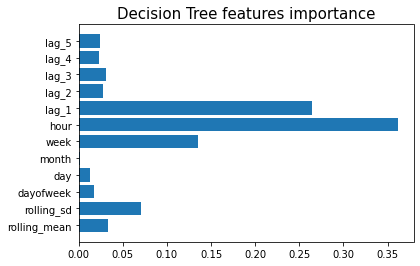

In [44]:
plt.barh(features_train.columns, grid.best_estimator_[1].feature_importances_)
plt.title('Decision Tree features importance', size=15)
plt.show()

### Random Forest

In [45]:
%%time
#Set pipeline
pipe = Pipeline([('scalar',MinMaxScaler()), ('regressor',RandomForestRegressor(random_state=12345))])

#Parameters for GridSearchCV
parameters = {'scalar': [MinMaxScaler(),StandardScaler()], 'regressor__max_depth':[50,100],
             'regressor__n_estimators':[100,200]}

#Fit the pipeline
pipe.fit(features_train, target_train)

#Grid results
grid = GridSearchCV(pipe, parameters, cv=tscv, verbose=0, refit=True, scoring=scorer ).fit(features_train, target_train)

train_rmse = grid.score(features_train, target_train)
print('Train set score:', train_rmse)
print()

test_rmse = grid.score(features_test, target_test)
print('Test set score:', test_rmse)
print()
print('Best parameters:',grid.best_params_)
print()
print('Best estimator:',grid.best_estimator_)

models_data = models_data.append({'model_name':'RandomForest', 'train_RMSE': train_rmse, 'test_RMSE':test_rmse}, ignore_index=True)

Train set score: 8.24624543082434

Test set score: 44.9580601292831

Best parameters: {'regressor__max_depth': 50, 'regressor__n_estimators': 100, 'scalar': StandardScaler()}

Best estimator: Pipeline(steps=[('scalar', StandardScaler()),
                ('regressor',
                 RandomForestRegressor(max_depth=50, random_state=12345))])
Wall time: 1min 11s


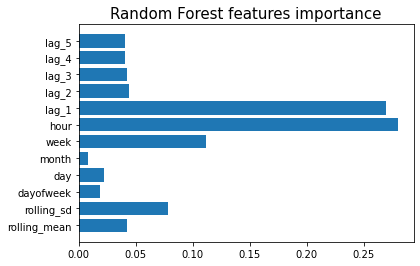

In [47]:
plt.barh(features_train.columns, grid.best_estimator_[1].feature_importances_)
plt.title('Random Forest features importance', size=15)
plt.show()

### XGBoost

In [69]:
%%time
#Set pipeline
pipe = Pipeline([('scalar',MinMaxScaler()), ('regressor',XGBRegressor(random_state=12345,verbosity = 0))])

#Parameters for GridSearchCV
parameters = {'scalar': [MinMaxScaler(),StandardScaler()], 'regressor__eta':[0.1, 0.2, 0.3],
             'regressor__booster':['gbtree','gblinear']}

#Fit the pipeline
pipe.fit(features_train, target_train)

#Grid results
grid = GridSearchCV(pipe, parameters, cv=tscv, verbose=0, refit=True, scoring=scorer ).fit(features_train, target_train)

train_rmse = grid.score(features_train, target_train)
print('Train set score:', train_rmse)
print()

test_rmse = grid.score(features_test, target_test)
print('Test set score:', test_rmse)
print()
print('Best parameters:',grid.best_params_)
print()
print('Best estimator:',grid.best_estimator_)

models_data = models_data.append({'model_name':'XGBRegressor', 'train_RMSE': train_rmse, 'test_RMSE':test_rmse}, ignore_index=True)

Train set score: 37.333944840900976

Test set score: 79.99231136123373

Best parameters: {'regressor__booster': 'gblinear', 'regressor__eta': 0.1, 'scalar': MinMaxScaler()}

Best estimator: Pipeline(steps=[('scalar', MinMaxScaler()),
                ('regressor',
                 XGBRegressor(base_score=0.5, booster='gblinear',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, eta=0.1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, random_state=12345,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                        

### LGBMRegressor

In [54]:
%%time
#Set pipeline
pipe = Pipeline([('scalar',MinMaxScaler()), ('regressor',LGBMRegressor(random_state=12345))])

#Parameters for GridSearchCV
parameters = {'scalar': [MinMaxScaler(),StandardScaler()], 'regressor__eta':[0.1, 0.2, 0.3]}

#Fit the pipeline
pipe.fit(features_train, target_train)

#Grid results
grid = GridSearchCV(pipe, parameters, cv=tscv, verbose=0, refit=True, scoring=scorer ).fit(features_train, target_train)

train_rmse = grid.score(features_train, target_train)
print('Train set score:', train_rmse)
print()

test_rmse = grid.score(features_test, target_test)
print('Test set score:', test_rmse)
print()
print('Best parameters:',grid.best_params_)
print()
print('Best estimator:',grid.best_estimator_)

models_data = models_data.append({'model_name':'LGBMRegressor', 'train_RMSE': train_rmse, 'test_RMSE':test_rmse}, ignore_index=True)

Train set score: 14.160570665514351

Test set score: 44.5590962377905

Best parameters: {'regressor__eta': 0.1, 'scalar': StandardScaler()}

Best estimator: Pipeline(steps=[('scalar', StandardScaler()),
                ('regressor', LGBMRegressor(eta=0.1, random_state=12345))])
Wall time: 2.98 s


In [50]:
pd.set_option('display.float_format', '{:.3f}'.format)

In [55]:
models_data.drop_duplicates(subset=['model_name'],inplace=True)
models_data.sort_values(by='test_RMSE')

,model_name,train_RMSE,test_RMSE
8,LGBMRegressor,14.161,44.559
6,RandomForest,8.246,44.958
5,DecisionTree,14.033,48.608
3,Ridge,30.337,50.470
1,Linear_regression,30.331,50.584
2,Lasso,31.341,56.858
0,Sanity_check,38.679,58.856
7,XGBRegressor,37.334,79.992
4,SVR,31.719,87.178


### Best model Random LGBMRegressor

In [56]:
grid.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scalar', MinMaxScaler()),
                                       ('regressor',
                                        LGBMRegressor(random_state=12345))]),
             param_grid={'regressor__eta': [0.1, 0.2, 0.3],
                         'scalar': [MinMaxScaler(), StandardScaler()]},
             scoring=make_scorer(rmse))

In [58]:
train_lgbm_pred = grid.predict(features_train)

In [59]:
test_lgbm_pred = grid.predict(features_test)

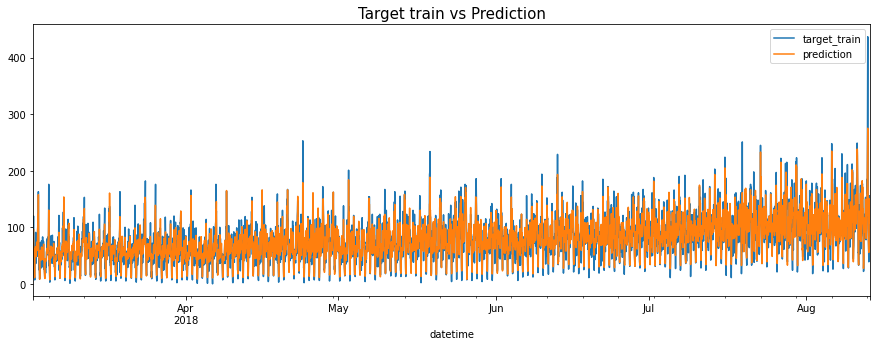

In [61]:
plt.figure(figsize=(15,5))
target_train.plot(label='target_train')
pd.Series(train_lgbm_pred, index=target_train.index).plot(label='prediction')
plt.title('Target train vs Prediction', size=15)
plt.legend()
plt.show()

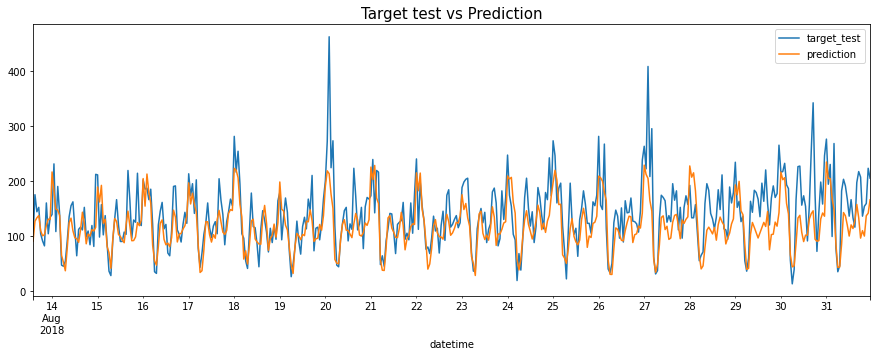

In [62]:
plt.figure(figsize=(15,5))
target_test.plot(label='target_test')
pd.Series(test_lgbm_pred, index=target_test.index).plot(label='prediction')
plt.title('Target test vs Prediction', size=15)
plt.legend()
plt.show()

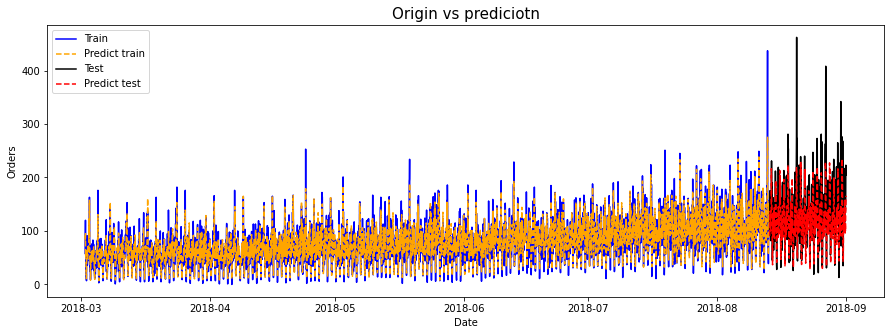

In [63]:
#See all grapths together

plt.figure(figsize=(15,5))
plt.title('Origin vs prediciotn', size=15)
plt.xlabel('Date')
plt.ylabel('Orders')
#Train
plt.plot(target_train.index, target_train, "-", color="blue",label="Train")

plt.plot(target_train.index, train_lgbm_pred,"--",color="orange",label="Predict train")

#Test
plt.plot(target_test.index,target_test,"-",color="black",label="Test")

plt.plot(target_test.index,test_lgbm_pred,"--",color="red",label="Predict test")

plt.legend(loc="upper left")
plt.show()

### Conclusion

In this project we exemined 'Sweet Lift Taxi' historical data on taxi orders at airports and noticed that we have increasing trend over the period of March 2018 to Aug 2018 and stationary seasonality with strong seasonality per hour. We added new features to train the model. The best features which improve performance were: hour, previos day orders and week. We trained different models using time seriese cross validation inside GridSearchCV: Linear regression, Lasso, Ridge, SVR, Decision tree, Random forest, XGBoost and LightGBM. The best model was Random forest with RMSE of: 44.32 which is lower than our goal of 48.